# Santé publique - (data: Open Food Facts): Sommaire

## Cleaning phase

### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, f_regression

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor


### Import data

In [6]:
path = '/Users/olivierdebeyssac/Open Classrooms/Data_scientist/projet_3/Data/fr.openfoodfacts.org.products.csv'
df = pd.read_csv(path, sep='\t')

/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/227090841.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')


In [7]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Synthèse data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


### Valeurs manquantes par type de données

In [9]:
df.isnull().mean()*100

code                         0.007170
url                          0.007170
creator                      0.000623
created_t                    0.000935
created_datetime             0.002806
                              ...    
carbon-footprint_100g       99.916452
nutrition-score-fr_100g     31.038245
nutrition-score-uk_100g     31.038245
glycemic-index_100g        100.000000
water-hardness_100g        100.000000
Length: 162, dtype: float64

Compte tenu des dimensions du df, pour plus de compréhension, on peut séparer les variables numériques et catégorielles

In [11]:
df_num = df.select_dtypes('float64')

In [12]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 106 entries, no_nutriments to water-hardness_100g
dtypes: float64(106)
memory usage: 259.4 MB


In [100]:
df_cat = df.select_dtypes('object')

In [327]:
#df_cat.info()

In [328]:
#df_cat.isnull().mean()*100

In [329]:
def aff_missing(df):
    # df représente df_num ou df_cat mais pas la concaténation des deux (dimensions trop inportantes)
    # définition seuil correspondant aux variables qui ont un excédent de val. manquantes
    
    l=[]
    
    seuil= 60 # Au dessus de seuil, on considère les variables comme non informatives. Seront exclues de l'analyse. 
    s = df.isnull().mean()*100
    s_above = s[s >= seuil]
    s_above=s_above.sort_values()
    df = pd.DataFrame(s_above, index=s_above.index)
    df.rename(columns={0:'values'},inplace=True)
    
    df_val = df.values
    df_val = df_val.reshape(-1,)
    
    nb = len(df)

    if nb > 40:
        nb_cols = 4
        nb_rows = 2
        taille = int(nb/(nb_cols * nb_rows))
    
        if nb%2 !=0:
            for i in range(nb_rows * nb_cols):
                
                if i < nb_rows * nb_cols:
                    l.append(df[i * taille: (i+1)* taille])
                    
                if i == nb_rows * nb_cols:
                    l.append(df[i * taille: (i+1)* taille + 1])
                    
        if nb%2 == 0:
            for i in range(nb_rows * nb_cols):
                    
                if i < nb_rows * nb_cols:
                    l.append(df[i * taille: (i+1)* taille])
                    
                if i == nb_rows * nb_cols:
                    l.append(df[i * taille: (i+1)* taille])
            
                    
        fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(8, 7))
        plt.tight_layout(pad=4.0)
    
        
        for j, ax in enumerate(axes.flatten()):
            data = l[j].values
            data = data.reshape(-1,)
            sns.barplot(x=data, y=l[j].index,ax=ax)
            
            ax.set_xticklabels(data,fontsize=6, rotation=45)
            ax.set_yticklabels(l[j].index, fontsize=6)
        
        plt.show()

#=================================================================================================================#
    
    if nb <= 40:
        nb_cols = 4
        nb_rows = 2
        taille = int(nb/(nb_cols * nb_rows))
    
        if nb%2 !=0:
            for i in range(nb_rows * nb_cols):
                
                if i < nb_rows * nb_cols:
                    l.append(df[i * taille: (i+1)* taille])
                    
                if i == nb_rows * nb_cols:
                    l.append(df[i * taille: (i+1)* taille + 1])
                    
        if nb%2 == 0:
            for i in range(nb_rows * nb_cols):
                    
                if i < nb_rows * nb_cols:
                    l.append(df[i * taille: (i+1)* taille])
                    
                if i == nb_rows * nb_cols:
                    l.append(df[i * taille: (i+1)* taille])
            
                    
        fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(9, 7))
        plt.tight_layout(pad=4.0)
    
        
        for j, ax in enumerate(axes.flatten()):
            data = l[j].values
            data = data.reshape(-1,)
            sns.barplot(x=data, y=l[j].index,ax=ax)
            
            ax.set_xticklabels(data,fontsize=6, rotation=45)
            ax.set_yticklabels(l[j].index, fontsize=6)
        
        plt.show()
        
    feature_names = list(df.index)

    return feature_names
    

/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/1025782219.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data,fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/1025782219.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data,fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/1025782219.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data,fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/1025782219.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data,fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/1025782219.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.s

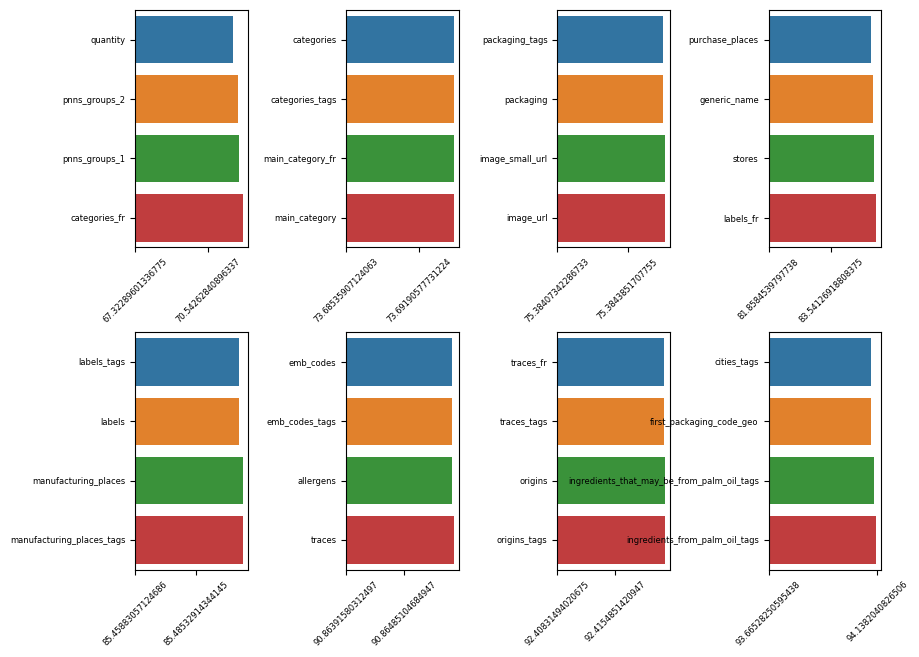

In [332]:
features_cat_tobe_excl = aff_missing(df_cat)

/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/1025782219.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data,fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/1025782219.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data,fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/1025782219.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data,fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/1025782219.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data,fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/1025782219.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.s

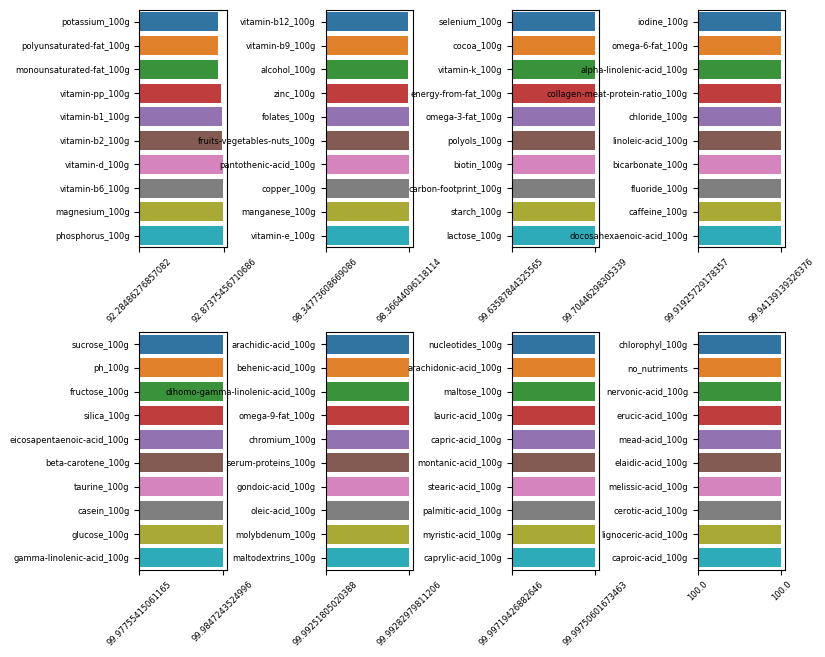

In [333]:
features_num_tobe_excl = aff_missing(df_num)

### Suppression features non informatives, set numérique

In [334]:
df_num.drop(features_num_tobe_excl, axis=1, inplace=True)

In [338]:
df_num.head(3)

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,2243.0,28.57,28.57,0.0,0.018,64.29,14.29,3.6,3.57,0.000,0.00,0.0,0.0214,0.000,0.00129,14.0,14.0
2,0.0,0.0,0.0,1941.0,17.86,0.00,0.0,0.000,60.71,17.86,7.1,17.86,0.635,0.25,0.0,0.0000,0.071,0.00129,0.0,0.0


In [335]:
df_num.isnull().mean()*100

additives_n                                22.393787
ingredients_from_palm_oil_n                22.393787
ingredients_that_may_be_from_palm_oil_n    22.393787
energy_100g                                18.598568
fat_100g                                   23.967491
saturated-fat_100g                         28.437021
trans-fat_100g                             55.327148
cholesterol_100g                           55.080244
carbohydrates_100g                         24.061951
sugars_100g                                23.630803
fiber_100g                                 37.374210
proteins_100g                              18.969860
salt_100g                                  20.345292
sodium_100g                                20.359944
vitamin-a_100g                             57.117828
vitamin-c_100g                             56.085007
calcium_100g                               56.027958
iron_100g                                  56.211265
nutrition-score-fr_100g                    31.

### Suppression features non informatives, set catégoriel

In [336]:
df_cat.drop(features_cat_tobe_excl, axis=1, inplace=True)

In [337]:
df_cat.isnull().mean()*100

code                       0.007170
url                        0.007170
creator                    0.000623
created_t                  0.000935
created_datetime           0.002806
last_modified_t            0.000000
last_modified_datetime     0.000000
product_name               5.537266
brands                     8.857382
brands_tags                8.859876
countries                  0.087289
countries_tags             0.087289
countries_fr               0.087289
ingredients_text          22.386617
serving_size              34.118003
additives                 22.404387
additives_tags            51.778834
additives_fr              51.778834
nutrition_grade_fr        31.038245
states                     0.014340
states_tags                0.014340
states_fr                  0.014340
dtype: float64

In [349]:
df_cat.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,...,countries_fr,ingredients_text,serving_size,additives,additives_tags,additives_fr,nutrition_grade_fr,states,states_tags,states_fr
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,...,France,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com..."
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,NaN,d,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl..."
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,Torn & Glasser,torn-glasser,...,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,NaN,b,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl..."


### Distribution set numérique et valeurs remarquables.

Affichage sous forme de boxplot de la distribution des valeurs pour le set numérique

In [346]:
def affiche(df):
    #print(len(df.columns))
    if len(df.columns)%2 == 0:
        n_rows = int(len(df.columns)/4)
        n_cols = 4
        
    else:
        n_rows = int(len(df.columns)/3)
        n_cols = int(len(df.columns)/n_rows) + 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,12))
    plt.tight_layout(pad=3.0)
    
    for ligne, ax in enumerate(axes.flatten()):
        sns.boxplot(y=df.iloc[:,ligne], ax=ax)
        ax.set_ylabel(df.columns[ligne],fontsize=7)
        ax.tick_params(labelsize=6)

    plt.show()
    return

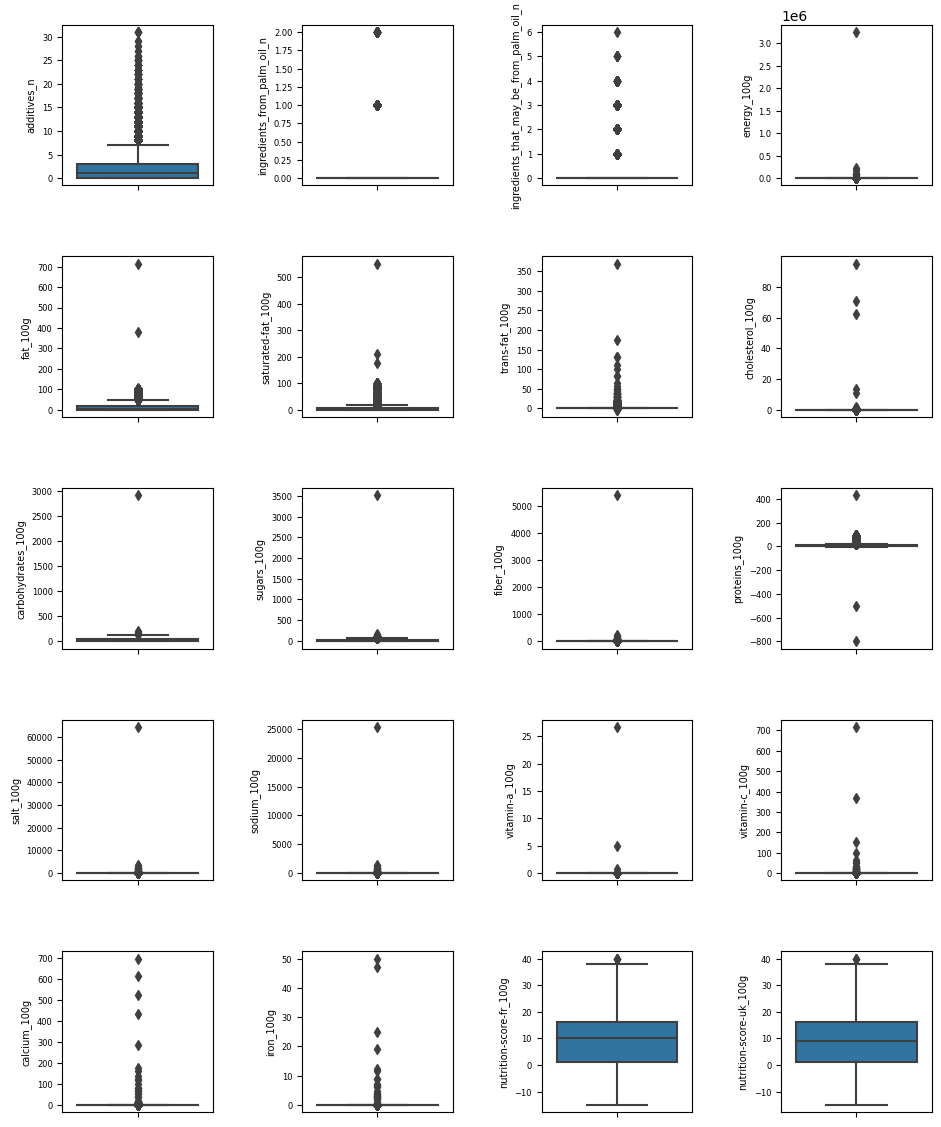

In [347]:
affiche(df_num)

Calcul des valeurs remarquables par variable numérique.

In [373]:
def val_remarquables(df):
    col_names = df.columns
    s_var = df_num.var(axis=0)
    s_mean = df_num.mean(axis=0)
    s_max = df_num.max(axis=0)
    s_et = df_num.std(axis=0)
    arr = np.array([s_var, s_mean, s_max, s_et])
    #print(arr)
    
    df = pd.DataFrame(arr, columns=col_names, index= ['variance', 'moyenne', 'max', 'écart type'])
    #print(df.head(3))
    
    
    return df

In [374]:
df_val_remq = val_remarquables(df_num)

In [375]:
df_val_remq

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
variance,6.260101,0.019747,0.072473,4.156580e+07,309.012335,64.228013,2.372286,0.128208,883.975142,498.507629,165.574564,70.712193,16453.052936,2550.697238,0.005370,5.001712,11.010870,0.045971,82.009378,84.338312
moyenne,1.936024,0.019659,0.055246,1.141915e+03,12.730379,5.129932,0.073476,0.020071,32.073981,16.003484,2.862111,7.075940,2.028624,0.798815,0.000397,0.023367,0.125163,0.003652,9.165535,9.058049
max,31.000000,2.000000,6.000000,3.251373e+06,714.290000,550.000000,369.000000,95.238000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,26.700000,716.981100,694.737000,50.000000,40.000000,40.000000
écart type,2.502019,0.140524,0.269207,6.447154e+03,17.578747,8.014238,1.540223,0.358062,29.731719,22.327284,12.867578,8.409054,128.269454,50.504428,0.073278,2.236451,3.318263,0.214408,9.055903,9.183589


Affichage des valeurs remarquables.

In [503]:
def aff_remq(df):
    
    fig, ax = plt.subplots(len(df.index), 1, figsize=(8,12))
    plt.tight_layout(pad=3.0)
    
    y= list(df.columns)
        
    for ligne, ax in enumerate(ax.flat):
        
        if int(ligne) < len(df):
            x=df.iloc[ligne:ligne+1, :].values.reshape(-1,)
            x = np.log(x)
            x= np.around(x,3)
            print(x)
            titre=df.index[ligne]
    
                
        if int(ligne) == len(df):
            x=df.iloc[:-1,:].values.reshape(-1,)
            x = np.log(x)
            x= np.around(x,3)
            titre=df.index[ligne]
            print(x)
        
        
        sns.barplot(x=x,y=y,ax=ax)
        ax.set_title(titre)
        ax.set_xticklabels(x, fontsize=6, rotation=45)
        ax.set_yticklabels(y, fontsize=6)

    plt.show()
    
    return
    

[ 1.834 -3.925 -2.625 17.543  5.733  4.162  0.864 -2.054  6.784  6.212
  5.109  4.259  9.708  7.844 -5.227  1.61   2.399 -3.08   4.407  4.435]
[ 0.661 -3.929 -2.896  7.04   2.544  1.635 -2.611 -3.908  3.468  2.773
  1.052  1.957  0.707 -0.225 -7.833 -3.756 -2.078 -5.612  2.215  2.204]
[ 3.434  0.693  1.792 14.995  6.571  6.31   5.911  4.556  7.978  8.166
  8.59   6.064 11.072 10.139  3.285  6.575  6.544  3.912  3.689  3.689]
[ 0.917 -1.962 -1.312  8.771  2.867  2.081  0.432 -1.027  3.392  3.106
  2.555  2.129  4.854  3.922 -2.613  0.805  1.199 -1.54   2.203  2.217]


/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/158438705.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/158438705.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/158438705.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=6, rotation=45)
/var/folders/vz/jqhjcz3j0xn4_ssg6jb109h00000gn/T/ipykernel_37446/158438705.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=6, rotation=45)


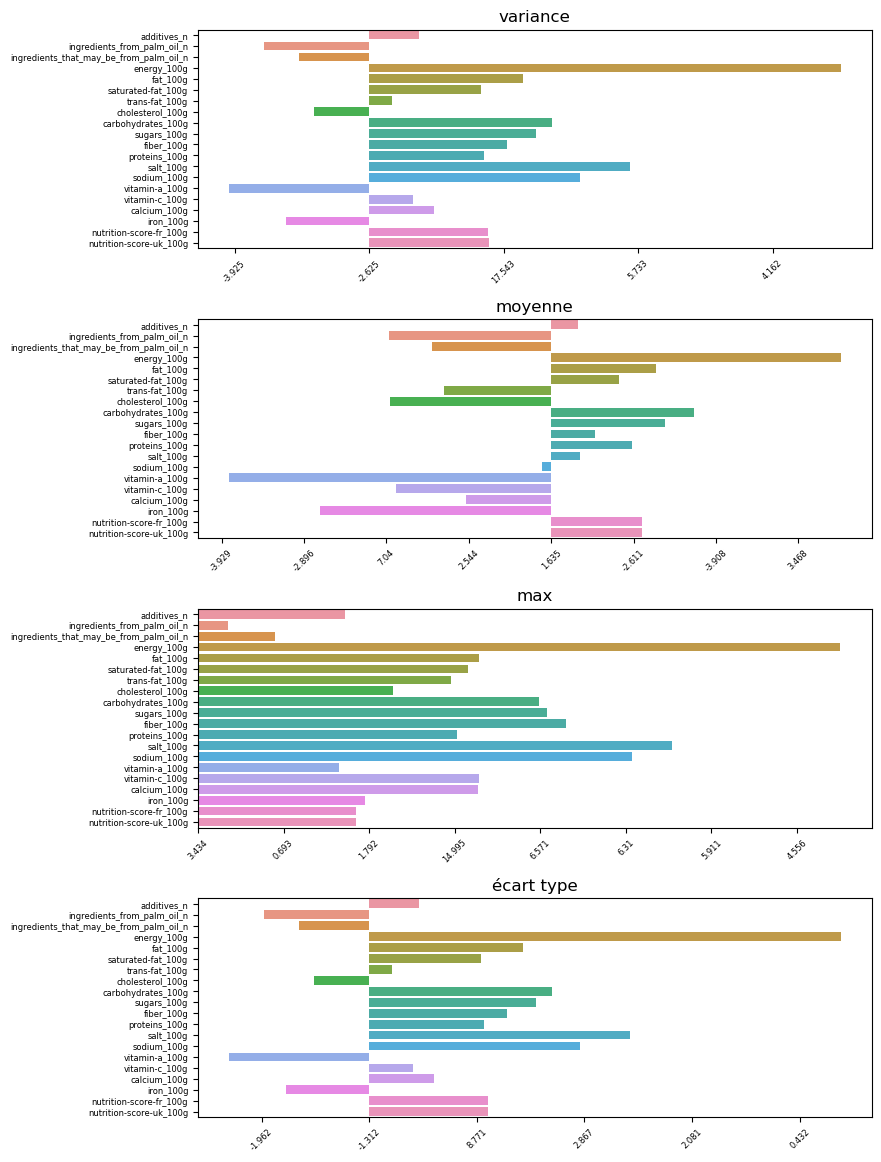

In [504]:
aff_remq(df_val_remq)

La visualisation de la distribution montre que les valeurs sont décentrées par rapport à la moyenne, sauf pour les variables "nutrition-score". Pour le remplacement des valeurs manquantes, on privilégira la valeur médiane. On note la présence d'outliers pour chaque variable. On procède aux étapes suivantes:
- Concaténer df_num et df_cat
- Pour chaque variable numérique, identifier les outliers et les types de produits pour lesquels on a ces valeurs. (quelle importance leur accorder compte tenu de l'objectif ?)

### Signification des "Outliers"

In [358]:
def verif(df_1, df_2):
    print("dimensions set numérique:{}".format(df_1.shape))
    print("dimensions set catégoriel:{}".format(df_2.shape))

    df_conc = pd.concat([df_1, df_2], axis=1)
    
    # dimensions de df_conc:
    long_c = df_conc.shape[0]
    larg_c = df_conc.shape[1]
    
    # vérification dimensions:
    long = df_1.shape[0]
    larg = df_1.shape[1] + df_2.shape[1]
    
    if long != long_c:
        print("dimension axe 0 fausse")
    else:
        print("ok")
        
    if larg != larg_c:
        print("dimension axe 1 fausse")
        print("ok")
        
    return df_conc




In [359]:
df_conc = verif(df_num, df_cat)

dimensions set numérique:(320772, 20)
dimensions set catégoriel:(320772, 22)
ok


In [361]:
#df_conc.info()

### Remplacement des valeurs manquantes, set numérique